In [ ]:
import os
import sqlite3
from multiprocessing import freeze_support
from modin.db_conn import ModinDatabaseConnection
import modin.pandas as mpd
%load_ext autoreload
%autoreload 2
os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
def load_data_from_db(con):
    try:
        df = mpd.read_sql("SELECT * FROM data", con)
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise


freeze_support()
dbfile = '/workspace/code/train_data_for_competition/training_set.db'

conn = ModinDatabaseConnection('sqlalchemy', f'sqlite:///{dbfile}')

# Can use get_connection to get underlying sqlalchemy engine
conn.get_connection()
db_df = load_data_from_db(conn)
print(db_df.head())

2025-03-09 20:05:10,967	INFO worker.py:1841 -- Started a local Ray instance.


In [ ]:
# "23-04 to 18-05"
db_df = db_df[db_df["Domain_Name"]!=1732927] # remove empty url
db_df["Datetime"] = mpd.to_datetime(db_df["Datetime"])
db_df["Datetime"]
# db_df.groupby("Device_ID").apply(lambda x: (x-x["Datetime"].min()).dt.days)

In [3]:
# %%writefile preprocessing.py
from sklearn.model_selection import train_test_split
def get_train_test_masks(domain_counts, test_size=0.2, random_state=42):
    # Get unique device IDs and their corresponding targets
    device_target_df = domain_counts.groupby('Device_ID')['Target'].first().reset_index()
    
    # Perform stratified split on device IDs
    train_device_ids, test_device_ids = train_test_split(
        device_target_df['Device_ID'],
        test_size=test_size,
        random_state=random_state,
        stratify=device_target_df['Target']
    )
    
    # Create mask for train/test split in domain_counts
    train_mask = domain_counts['Device_ID'].isin(train_device_ids)
    test_mask = domain_counts['Device_ID'].isin(test_device_ids)
    
    # Print statistics
    print(f"Total devices: {len(device_target_df)}")
    print(f"Train devices: {len(train_device_ids)}")
    print(f"Test devices: {len(test_device_ids)}")
    print(f"\nTrain samples: {len(domain_counts[train_mask])}")
    print(f"Test samples: {len(domain_counts[test_mask])}")
    
    # Print class distribution
    print("\nTarget distribution in train set:")
    print(domain_counts[train_mask].groupby('Target').size() / len(domain_counts[train_mask]))
    print("\nTarget distribution in test set:")
    print(domain_counts[test_mask].groupby('Target').size() / len(domain_counts[test_mask]))
    
    return train_mask, test_mask

def get_domain_counts(db_df, pivot=False):
    domain_counts = db_df.groupby(["Device_ID","Domain_Name","Target"]).count()
    domain_counts = domain_counts.reset_index()
    domain_counts = domain_counts[["Device_ID","Domain_Name","Target","Datetime"]]
    domain_counts.rename(columns={"Datetime":"count"}, inplace=True)
    if pivot:
        pivot_matrix = domain_counts.pivot(index='source', columns='target', values='count').fillna(0)
        return pivot_matrix
    return domain_counts
def get_device_domain_fractions(domain_counts,inplace=True):
    # Calculate total counts per device
    device_totals = domain_counts.groupby('Device_ID')['count'].sum()
    
    # Calculate fractions by dividing each count by the device total
    domain_fractions = domain_counts if inplace else domain_counts.copy()
    domain_fractions['fraction'] = domain_fractions.apply(
        lambda row: row['count'] / device_totals[row['Device_ID']], 
        axis=1
    )
    
    return domain_fractions
def compute_domain_target_correlation(domain_counts):
    # Group by Domain_Name and calculate mean Target and count
    domain_stats = domain_counts.groupby('Domain_Name').agg({
        'Target': 'mean',
        'count': ['mean', 'std', 'count']
    }).reset_index()
    
    # Flatten column names
    domain_stats.columns = ['Domain_Name', 'target_mean', 'count_mean', 'count_std', 'n_devices']
    
    # Calculate correlation coefficient
    # We only include domains that appear in multiple devices for statistical significance
    significant_domains = domain_stats[domain_stats['n_devices'] > 1]
    
    # Calculate correlation and p-value
    correlation = mpd.DataFrame({
        'Domain_Name': significant_domains['Domain_Name'],
        'target_correlation': significant_domains['target_mean'],
        'avg_count': significant_domains['count_mean'],
        'count_std': significant_domains['count_std'],
        'n_devices': significant_domains['n_devices']
    }).sort_values('target_correlation', ascending=False)
    
    return correlation

In [ ]:
print("keep in mind that the best resolution will be achieved with a resolution of urls/chain of urls, not domains")
print("Cluster url walks")
print("I want to cluster urls/url walks from a given domain, to 3 categories")
print("positive correlation, zero correlation, negative correlation, to_label")

### Getting Basic features ( Domain Counts )

In [ ]:

domain_counts = get_domain_counts(db_df)
del db_df
device_domain_fractions = get_device_domain_fractions(domain_counts)
domain_target_correlation = compute_domain_target_correlation(domain_counts)

train_mask, test_mask = get_train_test_masks(domain_counts)
train_devices = domain_counts.loc[train_mask,"Device_ID"]
test_devices = domain_counts.loc[test_mask,"Device_ID"]




In [18]:
train_fraction_pivot_matrix = device_domain_fractions.pivot(index='Domain_Name', columns='Device_ID', values='fraction').fillna(0)

In [20]:
# %%writefile correlation.py
import numpy as np
import ray
@ray.remote
def calculate_chunk_correlation(matrix_centered, std_values, start_idx, end_idx, columns):
    # Calculate correlation for this chunk
    chunk = matrix_centered[:, start_idx:end_idx]
    # Avoid division by zero by handling zero standard deviations
    valid_std = (std_values > 0)
    chunk_corr = np.zeros((end_idx - start_idx, len(columns)))
    
    # Calculate correlation only for columns with non-zero standard deviation
    if valid_std.any():
        chunk_corr = np.dot(chunk.T, matrix_centered[:, valid_std])
        chunk_corr /= ((matrix_centered.shape[0] - 1) * 
                      np.outer(std_values[start_idx:end_idx], 
                             std_values[valid_std]))
    
    return start_idx, end_idx, chunk_corr
@ray.remote
def calculate_chunk_covariance(matrix_centered, start_idx, end_idx, columns):
    # Calculate covariance for this chunk
    chunk = matrix_centered[:, start_idx:end_idx]
    chunk_cov = np.dot(chunk.T, matrix_centered) / (matrix_centered.shape[0] - 1)
    
    return start_idx, end_idx, chunk_cov

def compute_chunked_covariance(pivot_matrix, batch_size=2000):
    # Convert to numpy array for faster computation
    matrix_dense = pivot_matrix.to_numpy()
    matrix_centered = matrix_dense - np.mean(matrix_dense, axis=0)

    # Initialize parameters
    n_cols = pivot_matrix.shape[1]
    futures = []

    # Submit tasks to Ray
    for i in range(0, n_cols, batch_size):
        batch_end = min(i + batch_size, n_cols)
        futures.append(calculate_chunk_covariance.remote(matrix_centered, i, batch_end, pivot_matrix.columns))

    # Collect results and combine
    cov_chunks = []
    for future in ray.get(futures):
        start_idx, end_idx, chunk_cov = future
        chunk_df = mpd.DataFrame(
            chunk_cov,
            index=pivot_matrix.columns[start_idx:end_idx],
            columns=pivot_matrix.columns
        )
        cov_chunks.append(chunk_df)

    # Combine all chunks
    return mpd.concat(cov_chunks)
def melt_covariance_matrix(covariance_matrix):
    # Reset index to make it a column
    melted = covariance_matrix.reset_index()
    
    # Melt the dataframe
    melted = melted.melt(
        id_vars=['Device_ID'],
        var_name='target',
        value_name='covariance'
    )
    
    # Rename the 'index' column to 'source'
    melted = melted.rename(columns={'Device_ID': 'source'})
    
    # Remove duplicate pairs (e.g., if A->B exists, remove B->A)
    melted = melted[melted['source'] < melted['target']]
    
    # Remove rows where source equals target
    melted = melted[melted['source'] != melted['target']]
    
    return melted.reset_index(drop=True)
def filter_and_transform_covariance(melted_covariance, abs_threshold=0.03, log_threshold=10):
    # Create a copy to avoid modifying the original dataframe
    result = melted_covariance
    # Create corrected_cov column
    result['corrected_cov'] = result['covariance'].copy()
    
    # Apply absolute threshold filter
    result.loc[abs(result['corrected_cov']) < abs_threshold, 'corrected_cov'] = 0
    
    # Apply log transformation for values above log_threshold
    high_vals_mask = abs(result['corrected_cov']) > log_threshold
    result.loc[high_vals_mask, 'corrected_cov'] = result.loc[high_vals_mask, 'corrected_cov'].apply(
        lambda x: np.log(abs(x)) * np.sign(x)
    )
    print(high_vals_mask.mean())
    
    return result

### Calculating Covariance/Correlation between domains


In [ ]:
# Get domain counts and create pivot matrix

# Compute covariance matrix and melt it
covariance_matrix = compute_chunked_covariance(train_fraction_pivot_matrix) * 100000
melted_cov = melt_covariance_matrix(covariance_matrix)
melted_cov["min_max_cov"] = (melted_cov["covariance"]-melted_cov["covariance"].min())/(melted_cov["covariance"].max()-melted_cov["covariance"].min())

# corrected_cov = filter_and_transform_covariance(melted_cov)



In [56]:
# %%writefile graph_model_funcs.py
from sklearn.model_selection import train_test_split
import torch
from torch_geometric.nn import Node2Vec
from torch_geometric.data import Data
import networkx as nx
import pandas as pd
import numpy as np


def create_graph_data(corrected_cov,weight_col):
    # Convert domain names to numerical indices
    unique_domains = list(set(corrected_cov['source']).union(corrected_cov['target']))
    domain_to_idx = {domain: idx for idx, domain in enumerate(unique_domains)}
    
    # Create edge index and edge weights
    edge_index = torch.tensor([
        [domain_to_idx[s] for s in corrected_cov['source']],
        [domain_to_idx[t] for t in corrected_cov['target']]
    ], dtype=torch.long)
    
    edge_weight = torch.tensor(corrected_cov[weight_col].values, dtype=torch.float)
    
    # Create PyTorch Geometric Data object
    data = Data(
        edge_index=edge_index,
        edge_attr=edge_weight,
        num_nodes=len(unique_domains)
    )
    return data, domain_to_idx

def train_node2vec(data, device='cuda', epochs=100):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = Node2Vec(
        data.edge_index,
        embedding_dim=128,
        walk_length=20,
        context_size=10,
        walks_per_node=10,
        p=1,
        q=1,
        sparse=True
    ).to(device)

    
    model.train()
            
    return model
@ray.remote
def _compute_device_embedding(device_id, group, embeddings, domain_mapping):
    valid_embeddings = []
    valid_weights = []
    
    for _, row in group.iterrows():
        domain = row['Domain_Name']
        if domain in domain_mapping:
            idx = domain_mapping[domain]
            valid_embeddings.append(embeddings[idx])
            valid_weights.append(row['fraction'])
    
    if valid_embeddings:
        valid_weights = np.array(valid_weights)
        valid_weights = valid_weights / valid_weights.sum()
        device_embedding = np.average(valid_embeddings, weights=valid_weights, axis=0)
        return device_id, device_embedding
    return device_id, None

def compute_device_embeddings(device_fractions, embeddings, domain_mapping):
    # Group device fractions by Device_ID
    grouped_fractions = device_fractions.groupby('Device_ID')
    
    # Create remote tasks
    futures = [
        _compute_device_embedding.remote(device_id, group, embeddings, domain_mapping)
        for device_id, group in grouped_fractions
    ]
    
    # Collect results
    results = ray.get(futures)
    
    # Convert results to dictionary
    device_embeddings = {
        device_id: embedding 
        for device_id, embedding in results 
        if embedding is not None
    }
    
    return device_embeddings



### Train Node2Vec

In [ ]:
# train_mask, test_mask = get_train_test_masks(domain_counts)
final_device_domain_fractions = device_domain_fractions[["Device_ID","Domain_Name","min_max_fraction"]].rename(columns={"Domain_Name":"target","Device_ID":"source","min_max_fraction":"weight"})
final_cov = melted_cov[["source","target","min_max_cov"]].rename(columns={"min_max_cov":"weight"})
final_df = mpd.concat([final_device_domain_fractions,final_cov],ignore_index=True)
data, domain_mapping = create_graph_data(final_df,weight_col="weight")

model = train_node2vec(data)
embeddings = model().detach().cpu().numpy()

In [68]:
node_map_df = pd.Series(domain_mapping,name="idx")


In [70]:
node_map_df

131072         0
2228226        1
131078         2
1835017        3
655381         4
           ...  
655329     25861
1834983    25862
1834989    25863
655354     25864
1572861    25865
Name: idx, Length: 25866, dtype: int64

### Infer Test Embeddings

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
import xgboost as xgb

# Get device embeddings for training and testing

train_emb_indices = node_map_df.loc[train_devices]
test_emb_indices = node_map_df.loc[test_devices]
train_device_embeddings = pd.DataFrame(embeddings[train_emb_indices],index=train_devices)
test_device_embeddings = pd.DataFrame(embeddings[test_emb_indices],index=test_devices)
domain_counts_w_index = domain_counts.drop_duplicates(subset="Device_ID").set_index("Device_ID")

# Prepare training data
X_train = train_device_embeddings
y_train = domain_counts_w_index.loc[train_devices, 'Target'].values

# Prepare test data
X_test = test_device_embeddings
y_test = domain_counts_w_index.loc[test_devices, 'Target'].values

# Initialize and train Logistic Regression
# Initialize and train XGBoost classifier
xgb_model = xgb.XGBRegressor(objective='binary:logistic', random_state=42)
xgb_model.fit(X_train, y_train)

# Get predictions and calculate ROC AUC score
y_pred_proba = xgb_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.5879


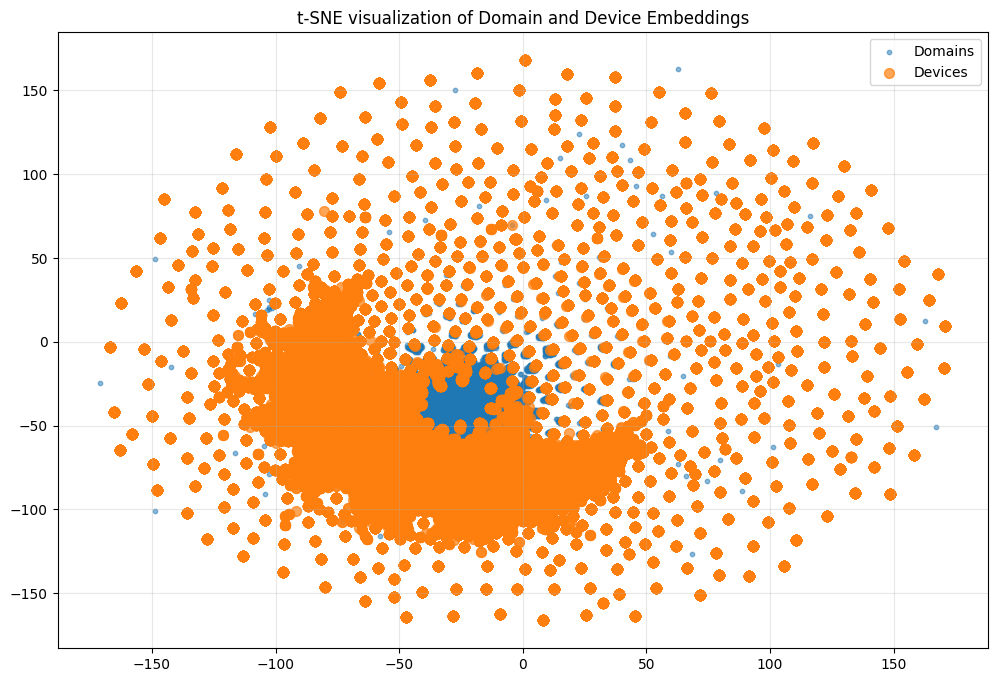

In [75]:
from sklearn.manifold import TSNE
import numpy as np

import matplotlib.pyplot as plt

# Create t-SNE model
tsne = TSNE(n_components=2, random_state=42)

# Combine all embeddings (both devices and domains)
all_embeddings = np.vstack([
    embeddings,  # Original domain embeddings
    np.vstack([train_device_embeddings, test_device_embeddings])  # Device embeddings
])

# Fit and transform the data
tsne_results = tsne.fit_transform(all_embeddings)

# Split results back into domains and devices
n_domains = embeddings.shape[0]
domain_tsne = tsne_results[:n_domains]
device_tsne = tsne_results[n_domains:]

# Create scatter plot
plt.figure(figsize=(12, 8))

# Plot domains with smaller dots
plt.scatter(domain_tsne[:, 0], domain_tsne[:, 1], 
           alpha=0.5, s=10, label='Domains')

# Plot devices with bigger dots
plt.scatter(device_tsne[:, 0], device_tsne[:, 1], 
           alpha=0.7, s=50, label='Devices')

plt.title('t-SNE visualization of Domain and Device Embeddings')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()